# an emission spectrum  check CO



In [1]:
#
#   Current Status: Feb. 25th (2021)
#
#   OK: forward JVP / HML RT alpha as a free parameter
#   Not work: primitive backward / alpha as a free parameter
#   Not implemented yet: VJP backward (something wrong for NumPyro) 
#
#   Current fiducial model: forward JVP
#   Updates: 1st sanity check with petit (Feb.23/2021)
#
#   ToDo:
#   Q(T) TIPS
# 

In [2]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.lpf import xsmatrix
from exojax.spec.clpf import cxsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
from exojax.spec.rtransfer import rtrun, dtaux 
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit
plt.style.use('bmh')

## INPUT MODEL

In [4]:
N=400
wav=np.linspace(22945,22985,N,dtype=np.float64)#AA
#N=1400
#wav=np.linspace(22945,23055,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

alpha_in=0.02
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = 1500.*(Parr/Parr[-1])**alpha_in

#loading molecular database (HITRAN2012/CO)
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2010.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)

In [5]:
#partition function ratio
#mdbCO_HITRAN=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
mdbCO_hitran=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
qt=mdbCO_hitran.Qr_layer(Tarr)

In [6]:
from scipy.constants import  m_u
mmw=2.33 #mean molecular weight
molmass=28.01 #molecular mass
MMR=0.01*np.ones_like(Tarr) #mass mixing ratio
g=1.e5 # gravity cm/s2

Xco=MMR*mmw/molmass #VMR

In [7]:
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr*Xco, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,molmass)

In [8]:
nu0=mdbCO.nu_lines
numatrix=make_numatrix0(nus,nu0)
xsm=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

## cheking d tau and contribution function

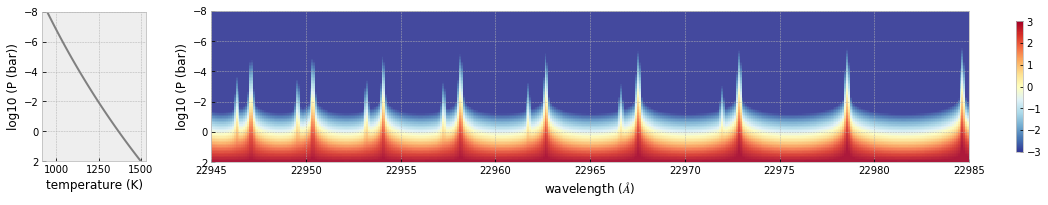

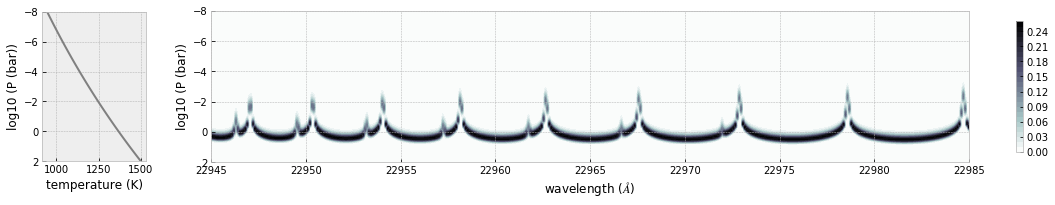

In [9]:
dtauM=dtaux(dParr,xsm,MMR,mmw,g)
plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
plotcf(nus,dtauM,Tarr,Parr,dParr,unit="AA") 

In [10]:
sourcef=planck.piBarr(Tarr,nus)

In [11]:
Fx0=rtrun(dtauM,sourcef)

In [15]:
%timeit Fx0=rtrun(dtauM,sourcef)

73.3 µs ± 547 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


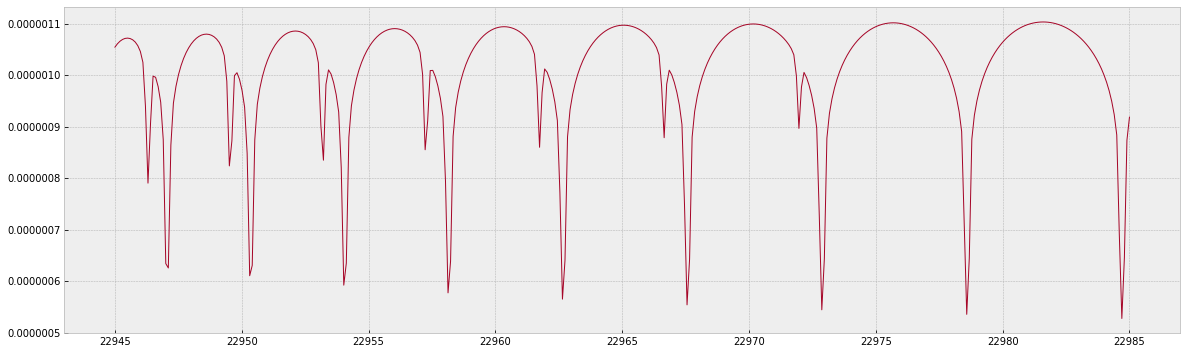

In [12]:
fig=plt.figure(figsize=(20,6.0))
plt.plot(wav[::-1],Fx0,lw=1,color="C1")
plt.savefig("highredCO.png")

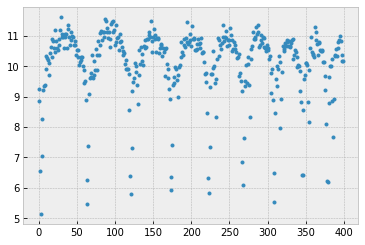

In [13]:
intfac=1.e7
sigin=0.25
N=len(Fx0)
data=Fx0*intfac+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [14]:
vgamma_hitran=jit(vmap(gamma_hitran,(0,0,0,None,None,None)))
vdoppler_sigma=jit(vmap(doppler_sigma,(None,0,None)))
vSij=jit(vmap(SijT,(0,None,None,None,0)))

In [15]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

/home/kawahara/anaconda3/lib/python3.7/site-packages/distributed/utils.py:139: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [16]:
#send molecular database to device
device_gamma_natural=jnp.array(gamma_natural(mdbCO.A))
device_logsij=jnp.array(mdbCO.logsij0)
device_nu_lines=jnp.array(mdbCO.nu_lines)
device_elower=jnp.array(mdbCO.elower)
device_n_air=jnp.array(mdbCO.n_air)
device_gamma_air=jnp.array(mdbCO.gamma_air)
device_gamma_self=jnp.array(mdbCO.gamma_self)
device_relative_Parr=jnp.array(Parr/Parr[-1])
device_Parr=jnp.array(Parr)
device_dParr=jnp.array(dParr[:,None]+np.zeros(np.shape(xsm)))
device_zerov=jnp.zeros(len(nus))
device_onev=jnp.ones(len(nus))

In [17]:
#epsilon=1.e-20
#ccgs=29979245800.0 
#intfaccgs=intfac/ccgs

def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(0.3))
    #T0 = numpyro.sample('T0', dist.Uniform(1400,1600))
    nu0 = numpyro.sample('nu0', dist.Uniform(-0.3,0.3))
    #alpha=0.02 
    alpha = numpyro.sample('alpha', dist.Uniform(0.019,0.021))

    #T-P model
    Tarr = 1500.*(device_relative_Parr)**alpha 
    
    #line computation
    SijM=vSij(Tarr,device_logsij,device_nu_lines,device_elower,qt)
    gammaLM = vgamma_hitran(device_Parr,Tarr,device_Parr*Xco,\
                            device_n_air, device_gamma_air, device_gamma_self) \
                            + device_gamma_natural 
    sigmaDM=vdoppler_sigma(device_nu_lines,Tarr,molmass)
    sourcef = planck.piBarr(Tarr,nus)
    
    xsm=cxsmatrix(numatrix-nu0,sigmaDM,gammaLM,SijM)   
    dtauM=dtaux(dParr,xsm,MMR,mmw,g)
    
    mu=rtrun(dtauM,sourcef)
    mu=intfac*A*mu
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [19]:
### class version

def model_c(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(0.3))
    #T0 = numpyro.sample('T0', dist.Uniform(1400,1600))
    nu0 = numpyro.sample('nu0', dist.Uniform(-0.3,0.3))
    #alpha=0.02 
    alpha = numpyro.sample('alpha', dist.Uniform(0.019,0.021))

    #T-P model
    Tarr = 1500.*(Parr/Parr[-1])**alpha 
    
    #line computation
    SijM=vSij(Tarr,mdbCO.logsij0,mdbCO.dev_nu_lines,mdbCO.elower,qt)
    gammaLM = vgamma_hitran(Parr,Tarr,Parr*Xco,\
                            mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self) \
                            + mdbCO.gamma_natural 
    sigmaDM=vdoppler_sigma(mdbCO.dev_nu_lines,Tarr,molmass)
    sourcef = planck.piBarr(Tarr,nus)
    
    xsm=cxsmatrix(numatrix-nu0,sigmaDM,gammaLM,SijM)   
    dtauM=dtaux(dParr,xsm,MMR,mmw,g)
    
    mu=rtrun(dtauM,sourcef)
    mu=intfac*A*mu
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
#nus, numatrix0 -> device?

In [19]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200

kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nus, y=data)
mcmc.print_summary()

sample: 100%|██████████| 300/300 [21:02<00:00,  1.35s/it, 23 steps of size 9.22e-02. acc. prob=0.91]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.99      0.00      0.99      0.98      1.00     30.77      1.00
     alpha      0.02      0.00      0.02      0.02      0.02     31.56      1.00
       nu0      0.00      0.00      0.00     -0.00      0.00    116.82      1.01
     sigma      0.25      0.01      0.25      0.23      0.26    253.20      1.00

Number of divergences: 0


In [20]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nus
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)

In [24]:
hpdi_mu = hpdi(predictions["y"], 0.9)

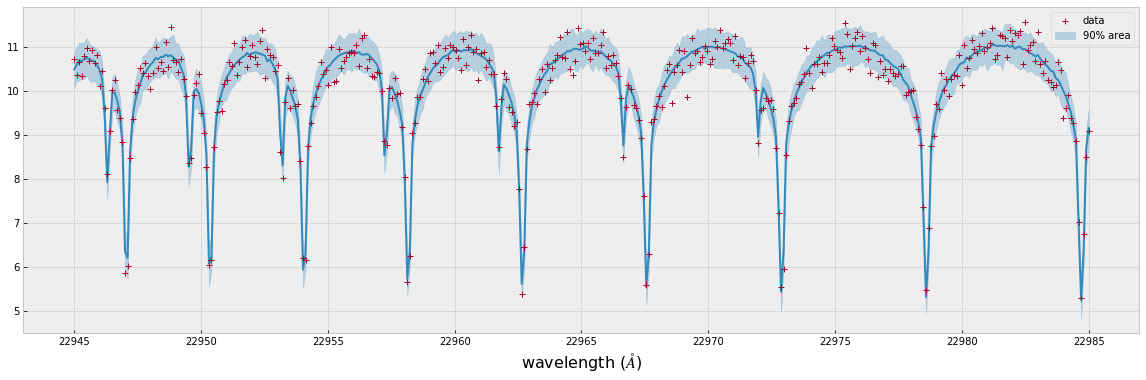

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))


#plt.plot(wav[::-1],Fx0,lw=1,color="C1",label="in")
ax.plot(wav[::-1],median_mu,color="C0")
ax.plot(wav[::-1],data,"+",color="C1",label="data")
ax.fill_between(wav[::-1], hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_CO_emission.png")
plt.show()

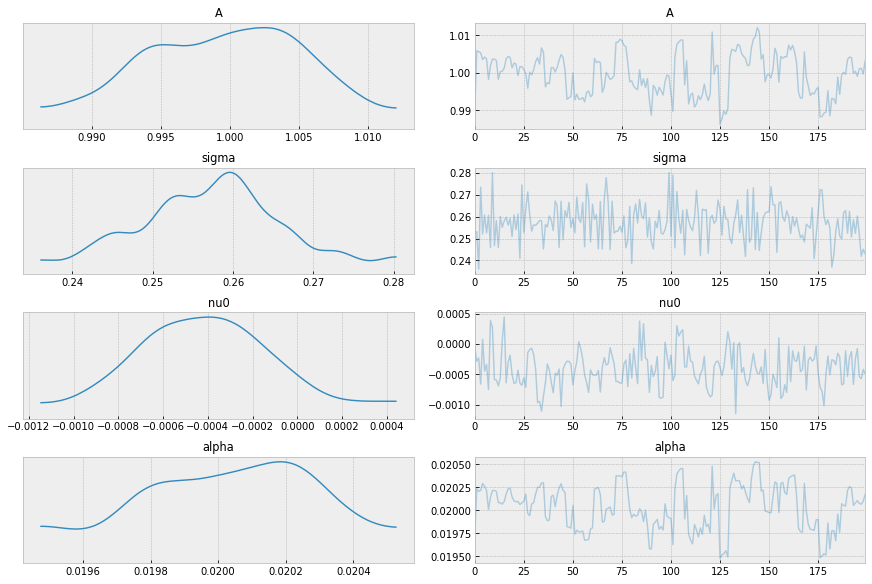

In [26]:
import arviz
arviz.plot_trace(mcmc, var_names=["A","sigma","nu0","alpha"])
plt.show()

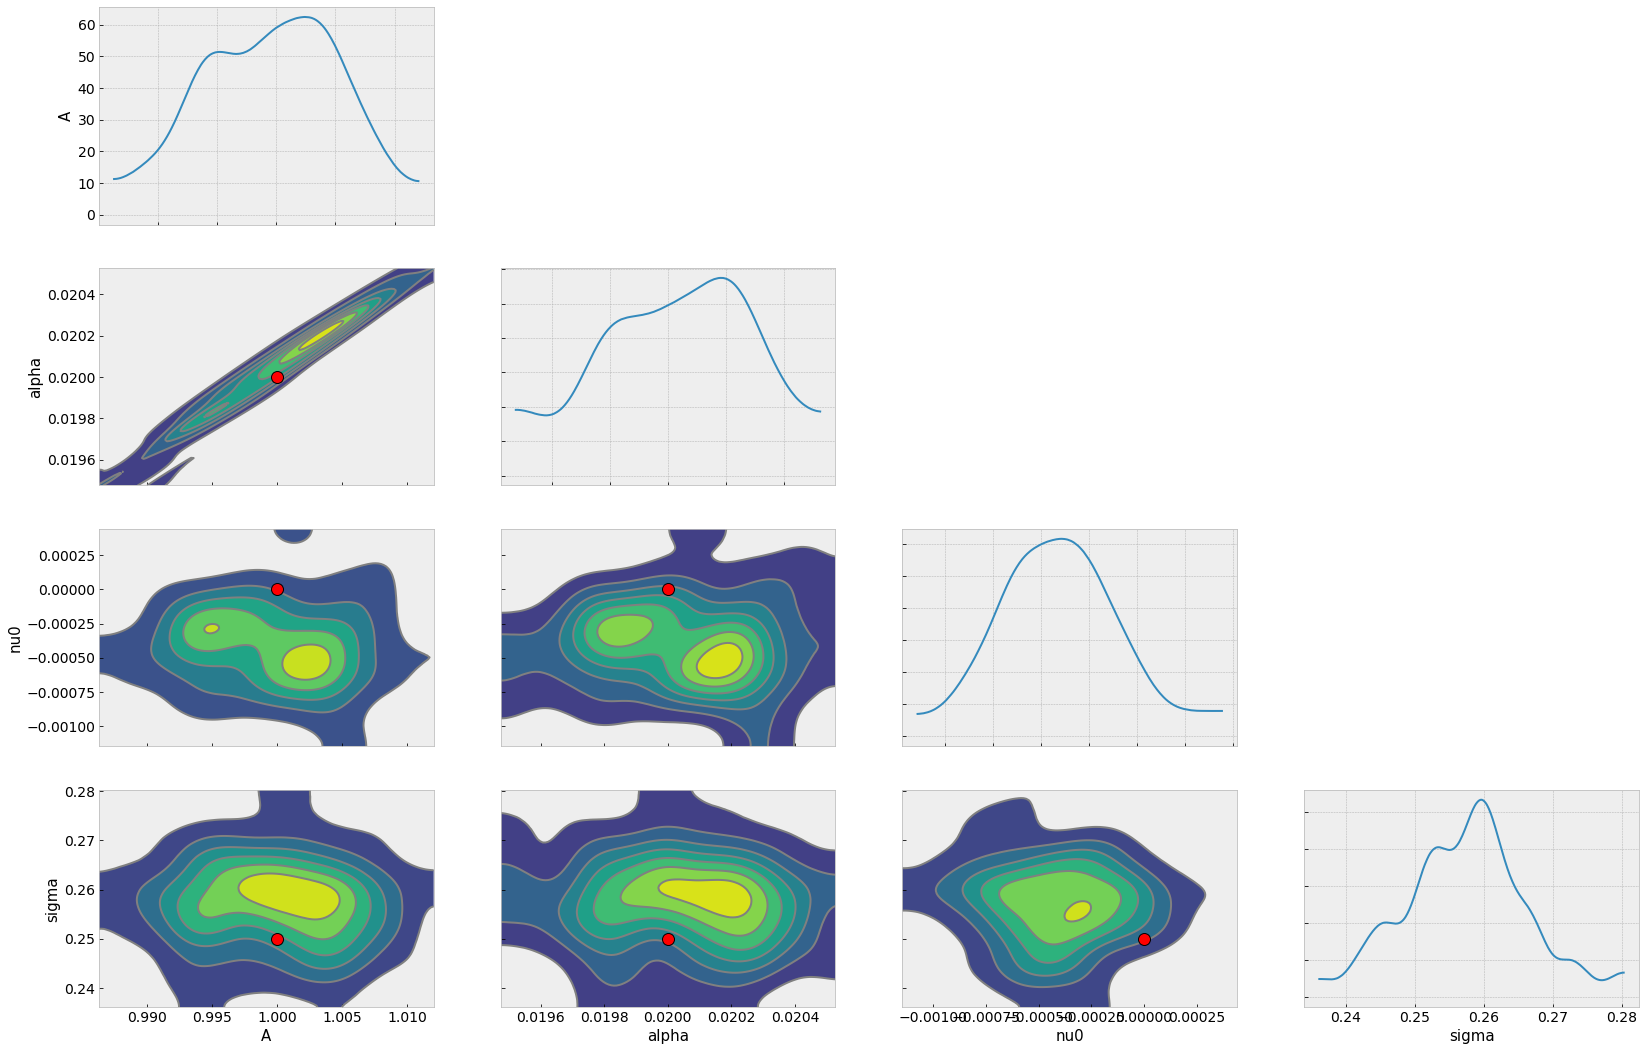

In [27]:
refs={}
refs["A"]=1.0
#refs["sD"]=sDfix
#refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=0.0
refs["alpha"]=0.02
#refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("../../documents/figures/posterior_CO.png")
plt.show()

In [70]:
Tarrx = 1500.*(device_relative_Parr[:,None])**posterior_sample["alpha"]

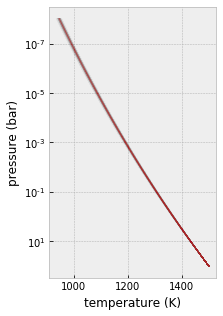

In [84]:
fig=plt.figure(figsize=(3,5))
for i in range(len(posterior_sample["alpha"])):
    plt.plot(Tarrx[:,i],Parr,alpha=0.005,color="C1")
plt.yscale("log")
plt.gca().invert_yaxis()
#plt.xscale("log")
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.savefig("../../documents/figures/TP_CO.png")
plt.show()